<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/mlp_mnist_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP on MNIST using TF 2.0

In [29]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
import sklearn
from time import time

In [30]:
# Tensorflow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print("tf version {}".format(tf.__version__))
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("TF cannot find GPU")

tf version 2.3.0
/device:GPU:0


In [31]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

(60000, 28, 28)
(10000, 28, 28)


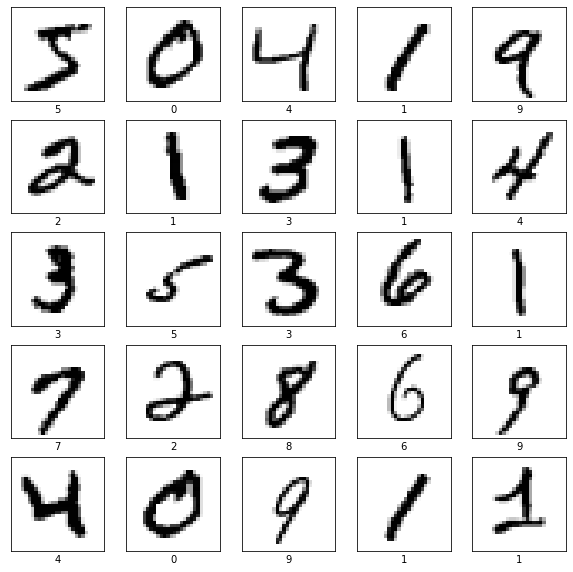

In [32]:
np.random.seed(0)

FASHION = False

if FASHION:
  (train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data() 
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
else:
  (train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data() 
  class_names = [str(x) for x in range(10)]
train_images = train_images / 255.0
test_images = test_images / 255.0

print(np.shape(train_images))
print(np.shape(test_images))
#(60000, 28, 28)
#(10000, 28, 28)


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
#save_fig("fashion-mnist-data.pdf")
plt.show()

In [33]:

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.summary()
    
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# We just train for 2 epochs because (1) it is faster, and
# (2) it produces more errors, which makes for a more interesting plot :)
time_start = time()
model.fit(train_images, train_labels, epochs=2)
print('time spent training {:0.3f}'.format(time() - time_start))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2316 - accuracy: 0.9318
Epoch 2/2
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1006 - accuracy: 0.9692
time spent training 7.392


In [34]:
predictions = model.predict(test_images)
print(np.shape(predictions))

# Overall accuracy
train_loss, train_acc = model.evaluate(train_images, train_labels)
print('Train accuracy:', train_acc)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

(10000, 10)
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0696 - accuracy: 0.9788
Train accuracy: 0.9787833094596863
313/313 [==============================] - 1s 2ms/step - loss: 0.0955 - accuracy: 0.9697
Test accuracy: 0.9696999788284302


In [35]:
# To apply prediction to a single image, we need to reshape to an (N,D,D) tensor
# where N=1
img = test_images[0]
img = (np.expand_dims(img,0))
print(img.shape)
predictions_single = model.predict(img)
print(predictions_single.shape)

(1, 28, 28)
(1, 10)


In [36]:
def plot_image_and_label(predictions_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = np.reshape(img, (28, 28)) # drop any trailing dimension of size 1
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("truth={}, pred={}, score={:2.0f}%".format(
      class_names[true_label],
      class_names[predicted_label],
      100*np.max(predictions_array)),
      color=color)

def plot_label_dist(predictions_array, true_label):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

(303,)
[  0   1   2   3   4   5   6   7   8 149 151 259 340 358 381]


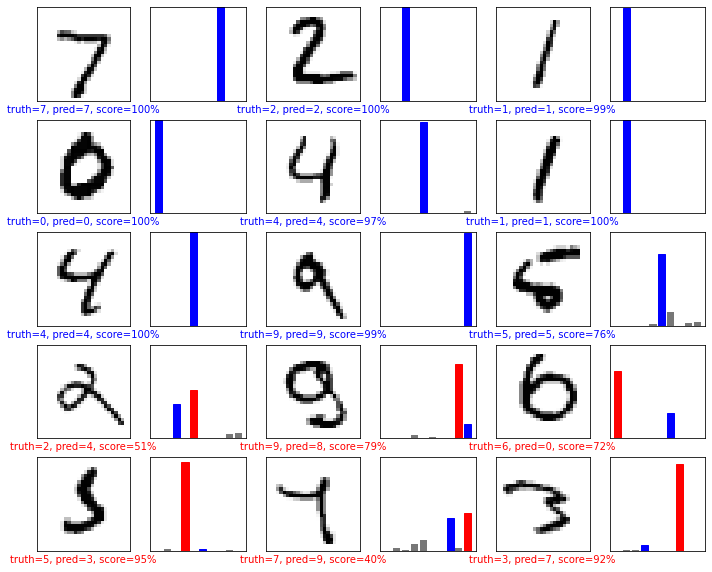

In [37]:
# Plot some test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red

# We select the first 9 images plus 6 error images
pred = np.argmax(predictions, axis=1)
errors = np.where(pred != test_labels)[0]
print(errors.shape)
ndx1 = range(9)
ndx2 = errors[:6]
ndx = np.concatenate((ndx1, ndx2))
print(ndx) # test images to show

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  n = ndx[i]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image_and_label(predictions[n], test_labels[n], test_images[n])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_label_dist(predictions[n], test_labels[n])
#save_fig("fashion-mlp-predictions-2epochs.pdf")
plt.show()